<a href="https://colab.research.google.com/github/varskann/BangPypers_talk/blob/main/image_classification/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification

### Pokemons.. Gotta classify'em all!!!

In [ ]:
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

     |████████████████████████████████| 788kB 10.6MB/s 
     |████████████████████████████████| 358kB 52.7MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.8 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
     |████████████████████████████████| 122kB 8.0MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.8 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.3.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.


In [ ]:
## Mounting the google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/gdrive


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 111.7 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


## Data Visualization

In [ ]:
import os
import glob

data_path = "drive/My Drive/data/"
classes = ['Horsea', 'Mankey', 'Mew', 'Scyther', 'Snorlax', 'Spearow', 'Tauros', 'Vaporeon', 'Venusaur', 'Vileplume']

## ~55 images per class, 60%-40% split
## If you need a test dataset as well .. go for 60-20-20 split instead
for _class in classes:
  print(f"class: {_class} | training images = {len(os.listdir(os.path.join(data_path, 'train', _class)))}, val images = {len(os.listdir(os.path.join(data_path, 'val', _class)))}")

class: Horsea | training images = 32, val images = 22
class: Mankey | training images = 32, val images = 22
class: Mew | training images = 32, val images = 22
class: Scyther | training images = 33, val images = 23
class: Snorlax | training images = 35, val images = 24
class: Spearow | training images = 33, val images = 22
class: Tauros | training images = 32, val images = 22
class: Vaporeon | training images = 35, val images = 24
class: Venusaur | training images = 38, val images = 27
class: Vileplume | training images = 33, val images = 23


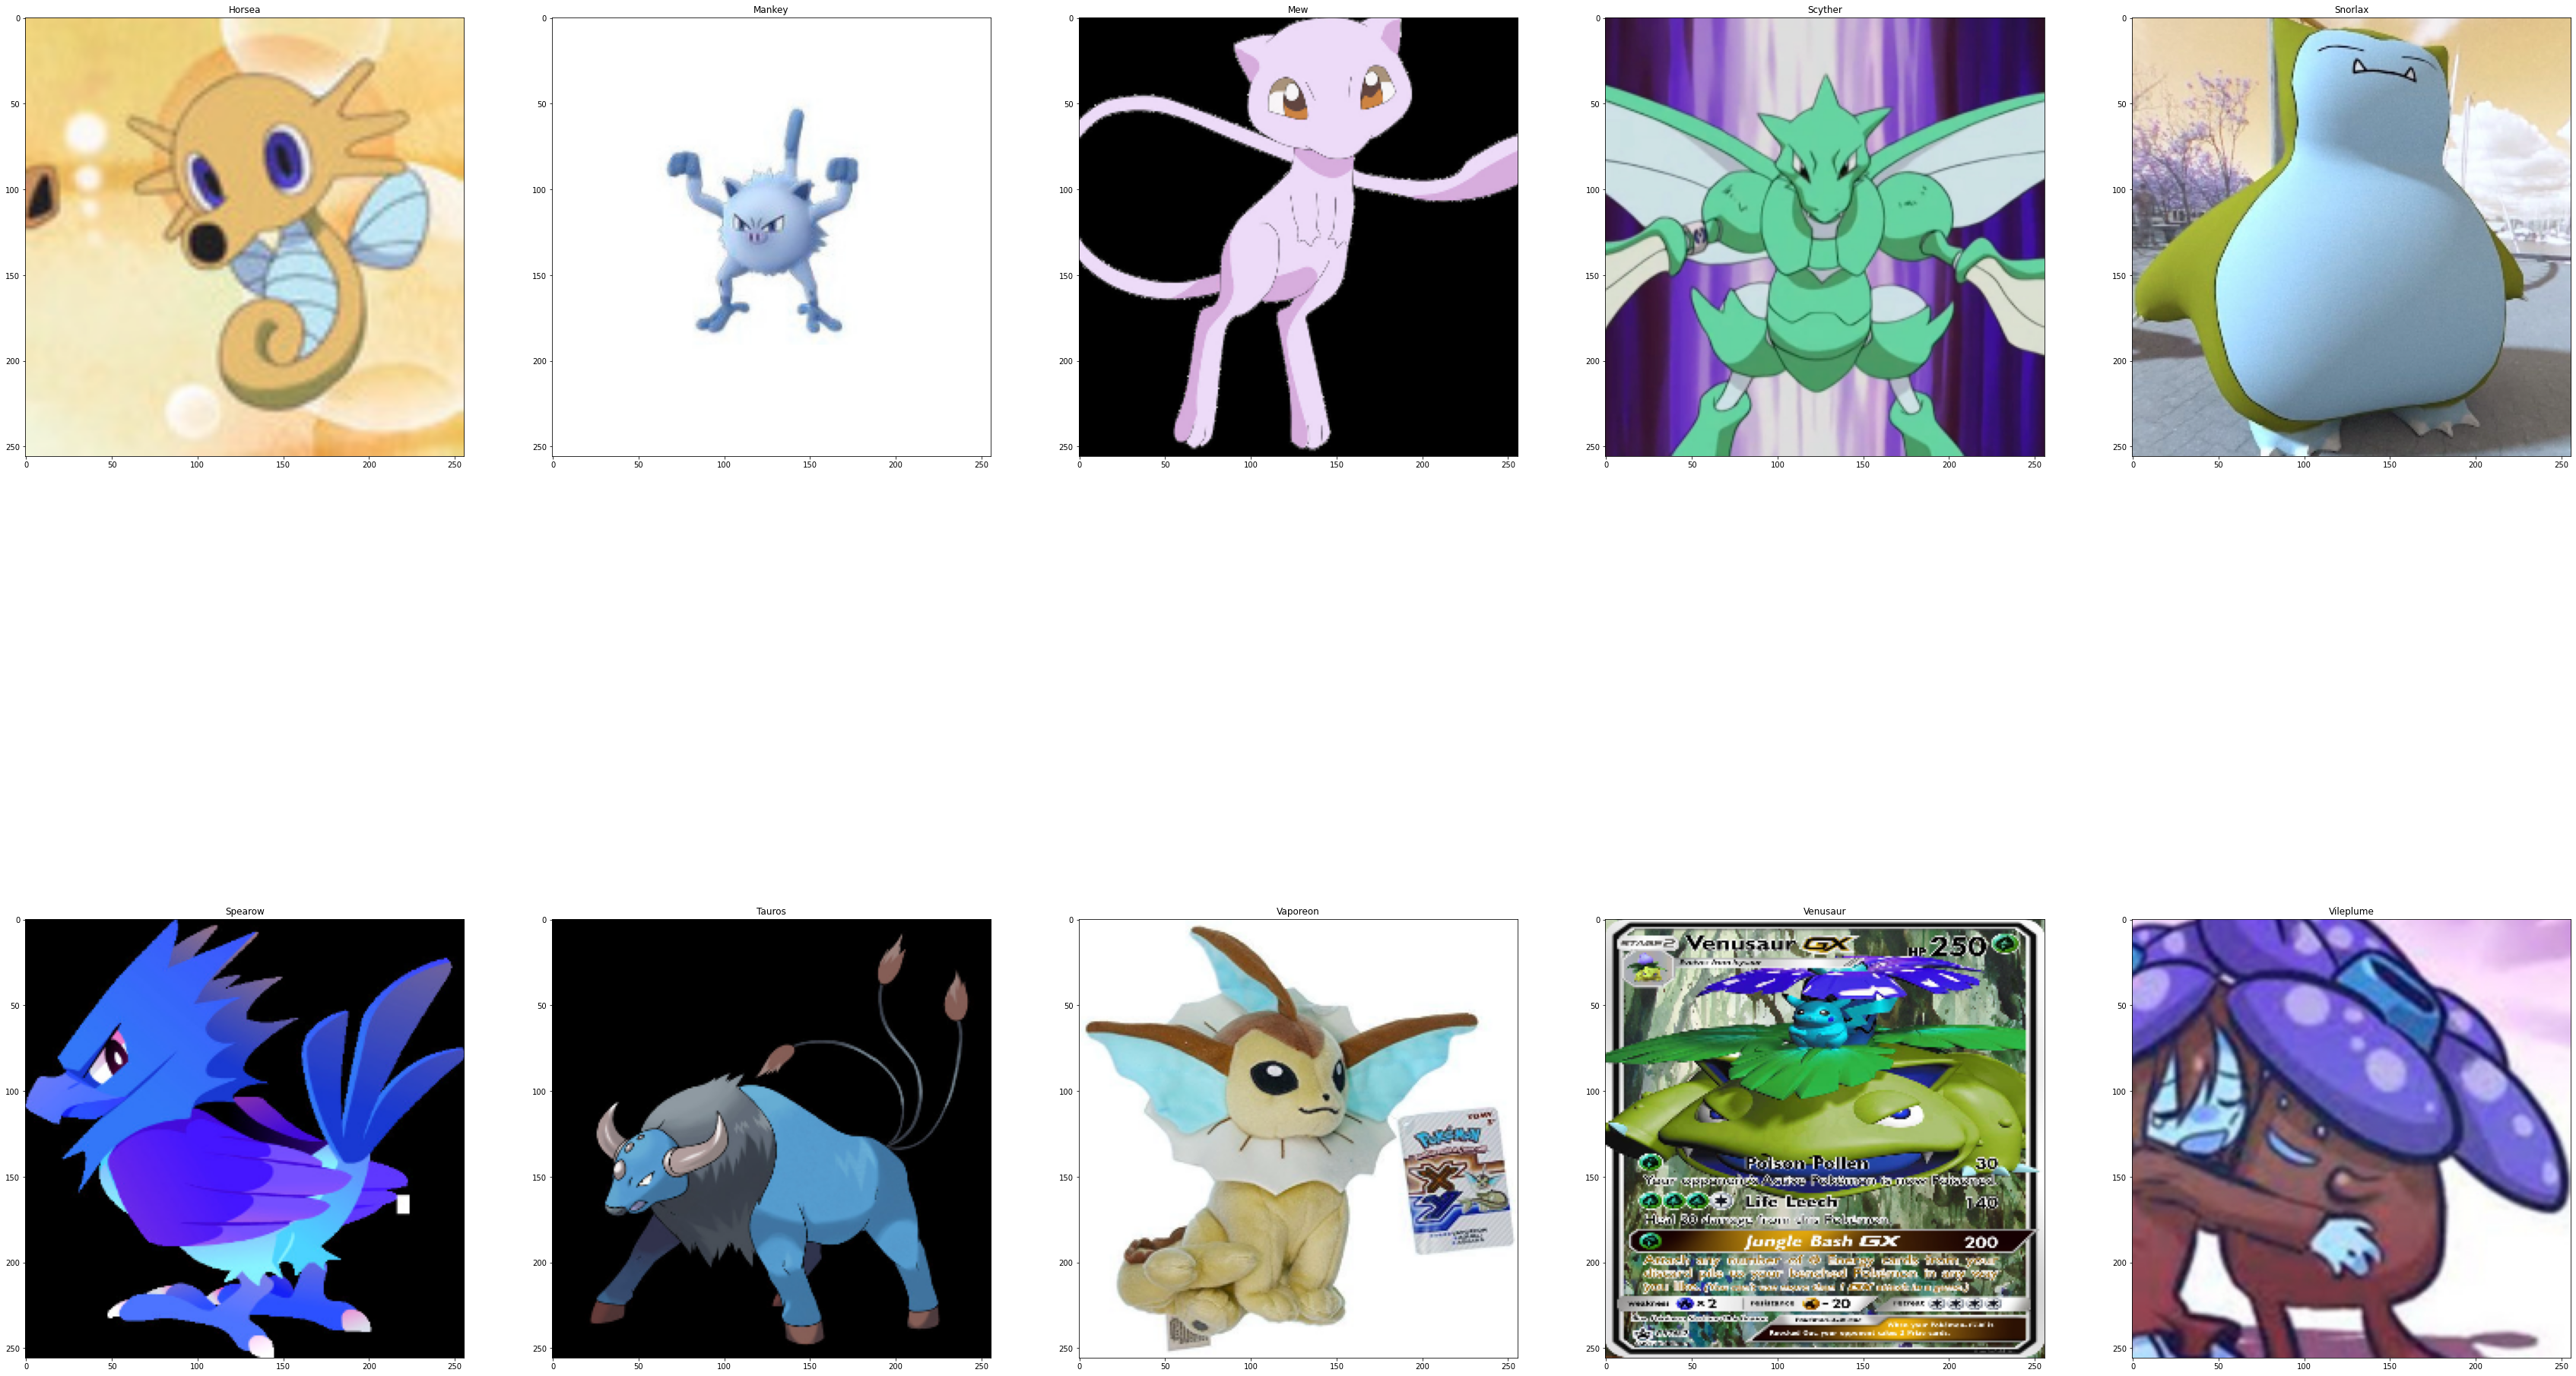

In [ ]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
  
images_demo = []
for _ci, _class in enumerate(classes):
  _image = glob.glob(os.path.join(data_path, 'train', _class, "*.jpg"))[0]
  _img = cv2.imread(_image)
  _img = cv2.resize(_img, (256, 256))
  images_demo.append(_img)

show_images(images_demo, cols=2, titles=classes)

## Supervised Classification: SVM

In [ ]:
%matplotlib inline
import os
import cv2
import glob
import time
import seaborn as sns
import numpy as np
from skimage import feature

from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV


class TrainSVM:
  def __init__(self):
    self.param_grid = [
                       {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                       {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
                       ]
    self.clf = None
    self.classes = ['Horsea', 'Mankey', 'Mew', 'Scyther', 'Snorlax', 'Spearow', 'Tauros', 'Vaporeon', 'Venusaur', 'Vileplume']
    self.base_path = "drive/My Drive/data/"

  def train(self, X, y):
    tstart = time.time()
    svc = svm.SVC()
    self.clf = GridSearchCV(svc, self.param_grid)
    self.clf.fit(X, y)
    tdelta = round(time.time() - tstart, 2)
    print(f"time taken to train SVM classifier for {len(self.classes)}: {tdelta}sec")

  
  def predict(self, X_test):
    y_pred = self.clf.predict(X_test)
    return y_pred

  def performance(self, y_test, y_pred):
    cf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=self.classes)
    prf = metrics.precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f"Avg Precision: {prf[0]}, Avg Recall: {prf[1]}, F1 score: {prf[2]}")
    sns.heatmap(cf_matrix, annot=True)

  def generate_data(self, label, dimension=(64, 64), ftype=None):
    tstart = time.time()
    features = []
    target = []

    for i, _class in enumerate(self.classes):
      images = glob.glob(os.path.join(self.base_path, label, _class, "*.jpg"))
      for img_path in images:
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, dimension)
        if not ftype:
          features.append(img_resized.flatten())
        
        elif ftype == "hog":
          features.append(self.hog_features(img_resized))

        target.append(_class)

    
    features = np.array(features)
    target = np.array(target)
    tdelta = round(time.time() - tstart, 2)
    print(f"time taken to generate {ftype} features for {label} data: {tdelta}sec")
    return features, target

 
  def hog_features(self, img):
    hog = cv2.HOGDescriptor()
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    return feature.hog(gray_img, orientations=9, pixels_per_cell=(10, 10),
		cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")


time taken to generate None features for train data: 2.63sec
time taken to generate None features for val data: 107.27sec
time taken to train SVM classifier for 10: 154.79sec
Avg Precision: 0.6703968488595895, Avg Recall: 0.6493506493506493, F1 score: 0.648735118074926


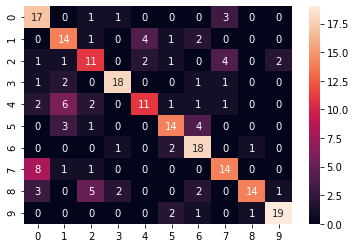

In [ ]:
## SVM classsification using flattened image features

svm_classifier = TrainSVM()
X_train, y_train = svm_classifier.generate_data("train", (64, 64))
X_test, y_test = svm_classifier.generate_data("val", (64, 64))

svm_classifier.train(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
svm_classifier.performance(y_test, y_pred)

time taken to generate hog features for train data: 4.19sec
time taken to generate hog features for val data: 2.55sec
time taken to train SVM classifier for 10: 55.52sec
Avg Precision: 0.5255636738468639, Avg Recall: 0.48484848484848486, F1 score: 0.48850586262104645


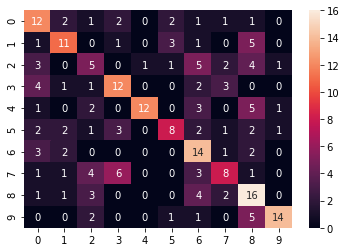

In [ ]:
## SVM classsification using HOG Features
svm_classifier = TrainSVM()
X_train, y_train = svm_classifier.generate_data("train", (128, 128), ftype="hog")
X_test, y_test = svm_classifier.generate_data("val", (128, 128), ftype="hog")

svm_classifier.train(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
svm_classifier.performance(y_test, y_pred)

## Supervised Classification: CNN (LeNet)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from torchvision import transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import skimage
from skimage import io


import copy
import random
import time
import os
import glob

In [ ]:
## Model Definition
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 32, 
                               kernel_size = 3,
                               padding = 1)
        
        self.conv2 = nn.Conv2d(in_channels = 32, 
                               out_channels = 16, 
                               kernel_size = 3,
                               padding = 1)
        
        self.fc_1 = nn.Linear(16 * 64 * 64, 1024)
        self.fc_2 = nn.Linear(1024, 128)
        self.fc_3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        return x, h

In [ ]:
transforms_ = [transforms.Resize(int(256 * 1.12), Image.BICUBIC),
                   transforms.RandomCrop(256),
                   transforms.RandomHorizontalFlip(),
                   transforms.ToTensor(),
                   transforms.Normalize((0.5,), (0.5,))]

In [ ]:
class PokemonDataSet(Dataset):
    def __init__(self, label, transform=None):
      self.classes = ['Horsea', 'Mankey', 'Mew', 'Scyther', 'Snorlax', 'Spearow', 'Tauros', 'Vaporeon', 'Venusaur', 'Vileplume']
      self.base_path = "drive/My Drive/data/"
      self.transform = transforms.Compose(transform)
      tstart = time.time()
      self.data = []
      
      for i, _class in enumerate(self.classes):
        images = glob.glob(os.path.join(self.base_path, label, _class, "*.jpg"))
        for img_path in images:
          self.data.append([img_path, i])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        img_path, target = self.data[idx % len(self.data)]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
          img = self.transform(img)

        sample = {'image': img, 'target': target}

        return sample

In [ ]:
train_data = PokemonDataSet(label="train", transform=transforms_)
train_data_loader = data.DataLoader(train_data,
                                    num_workers=1,
                                    batch_size=32,
                                    shuffle=True,
                                    pin_memory=True)

val_data = PokemonDataSet(label="val", transform=transforms_)
val_data_loader = data.DataLoader(val_data,
                                  num_workers=1,
                                  batch_size=16,
                                  pin_memory=True)

In [ ]:
OUTPUT_DIM = 10
model = LeNet(OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 67,247,898 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  for _batch in iterator:
    x = _batch["image"].to(device)
    y = _batch["target"].to(device)

    optimizer.zero_grad()    
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for _batch in iterator:
      x = _batch["image"].to(device)
      y = _batch["target"].to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_data_loader, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-modebl.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 4s
	Train Loss: 2.289 | Train Acc: 20.01%
	 Val. Loss: 2.125 |  Val. Acc: 18.33%
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 1.832 | Train Acc: 32.31%
	 Val. Loss: 1.727 |  Val. Acc: 40.42%
Epoch: 03 | Epoch Time: 0m 13s
	Train Loss: 1.306 | Train Acc: 52.52%
	 Val. Loss: 1.401 |  Val. Acc: 50.71%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 1.035 | Train Acc: 61.24%
	 Val. Loss: 1.153 |  Val. Acc: 60.71%
Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 0.790 | Train Acc: 73.74%
	 Val. Loss: 1.469 |  Val. Acc: 56.13%
Epoch: 06 | Epoch Time: 0m 13s
	Train Loss: 0.802 | Train Acc: 73.25%
	 Val. Loss: 1.320 |  Val. Acc: 62.26%
Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 0.667 | Train Acc: 77.39%
	 Val. Loss: 1.095 |  Val. Acc: 67.50%
Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 0.579 | Train Acc: 83.40%
	 Val. Loss: 1.044 |  Val. Acc: 70.71%
Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 0.479 | Train Acc: 85.06%
	 Val. Loss: 0.959 |  Val. Acc: 74.05%
Epoch: 10 | Epoch Ti